In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os

#training specific imports
import winsound
from keras.callbacks import ReduceLROnPlateau
from comparison_models import model_maker, models
from tensorflow.keras.optimizers import Adam
from time import perf_counter
import pandas as pd
from statistics import mean


In [2]:
# get data
train_dir = 'asl_alphabet_train/asl_alphabet_train/'
train_folders = os.listdir(train_dir)
test_dir = 'asl_alphabet_test/asl_alphabet_test/'
test_files = os.listdir(test_dir)


In [3]:
# Differrent preprocessing methdods here 
# Work in progress


# 1
def preprocess(img):
    # img = cv2.imread(filename,1)
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 2)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

#2
def preprocess2(img):
    # img = cv2.imread(filename,1)
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, 1.2)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img


In [23]:
image_generator = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess2)

# image_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255)


In [24]:
train_generator = image_generator.flow_from_directory(directory = train_dir, target_size = (96, 96), shuffle = True, seed = 13,
                                                     class_mode='categorical', batch_size=128, subset="training")

valid_gen = image_generator.flow_from_directory(directory=train_dir,
                                                target_size=(96, 96),
                                                batch_size=128, seed=13,
                                                class_mode='categorical', subset='validation',
                                                shuffle=False)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

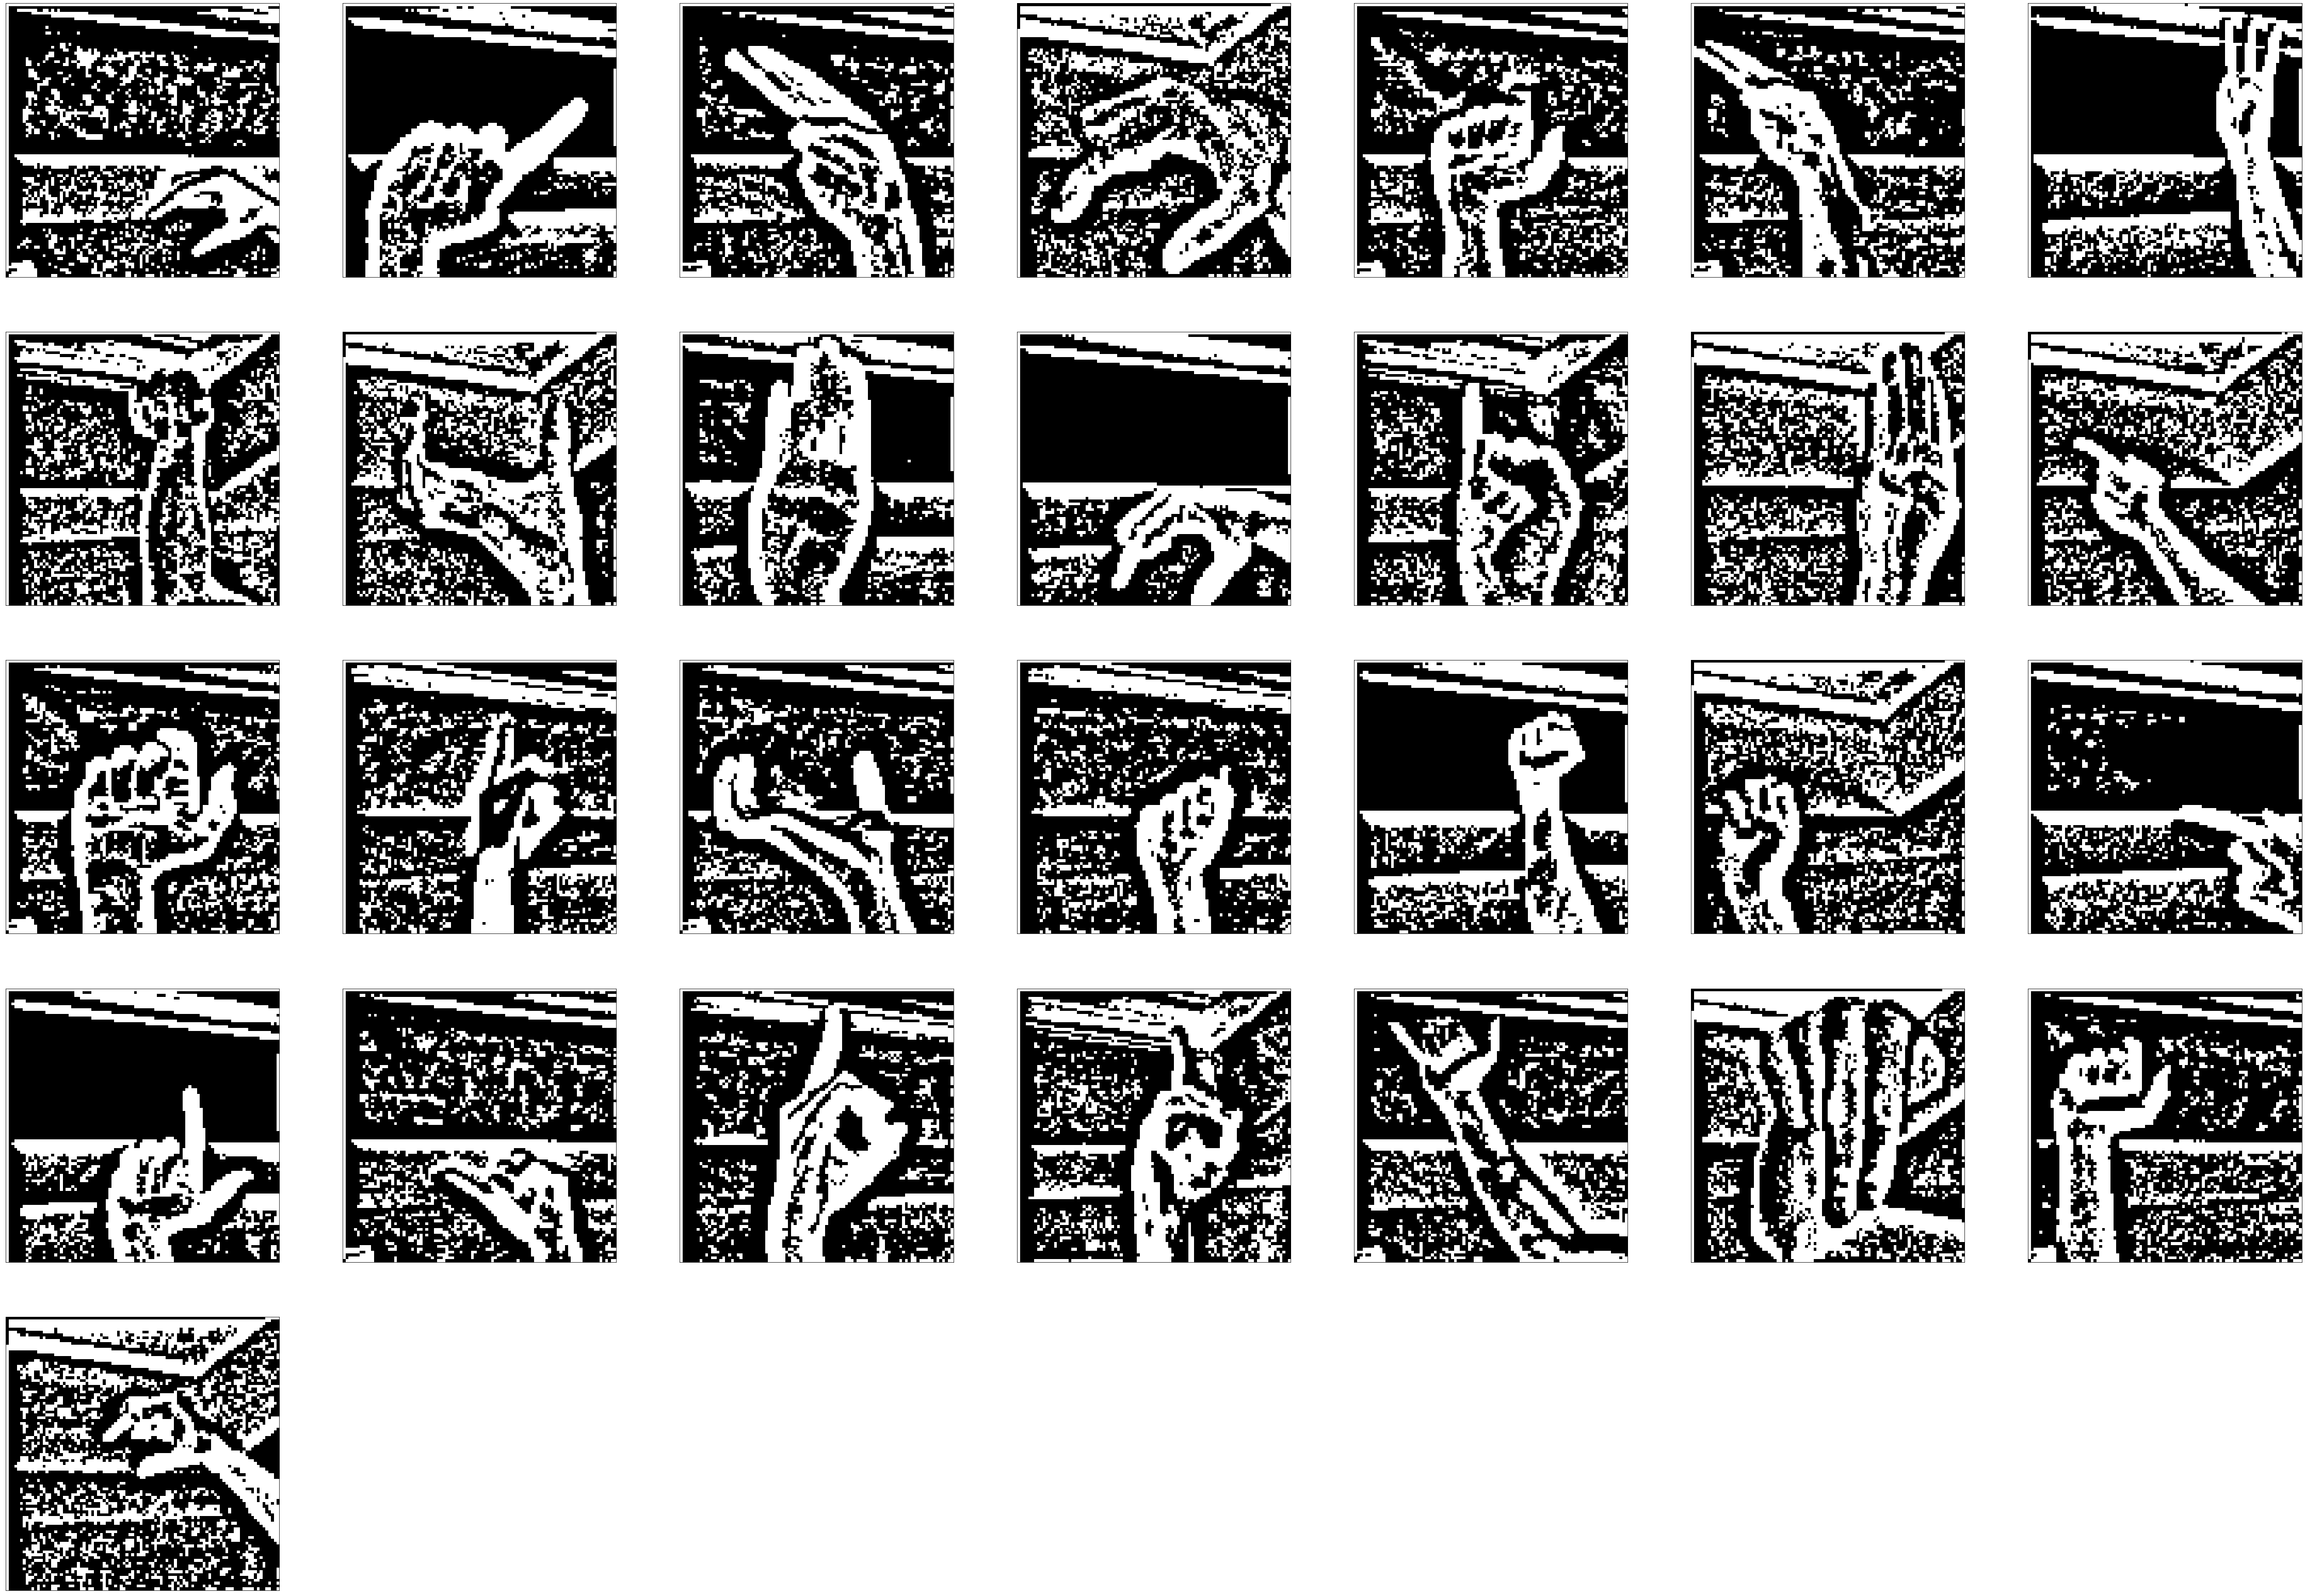

In [6]:
#output for testing
plt.figure(figsize=(80, 80))
for i in range(0, 29):
    plt.subplot(7, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_generator[0][0][i])


In [ ]:

test_gen = ImageDataGenerator().flow_from_directory(directory=test_dir,
                                                        target_size=(96, 96),
                                                        class_mode='categorical',
                                                        batch_size=4,
                                                        shuffle=False)


preprocess_test_gen =  ImageDataGenerator(preprocessing_function=preprocess2).flow_from_directory(directory=test_dir,
                                                target_size=(96,96),
                                                class_mode='categorical',
                                                batch_size=4,
                                                shuffle=False)


In [9]:

model_results = {
    'model' : [],
    'val_accuracy':[],
    'time_taken' : []
}


learning_rate = 0.0001
adam = Adam(learning_rate=learning_rate)

# --------------------------------------------- Main training loop here --------------------------------------
for i in models.keys():
    print("Training " , i)

    #get model 
    model = model_maker(i)
    # model.summary()

    model.compile(optimizer=adam, loss='categorical_crossentropy',
                metrics=["accuracy"])

    # Stop training if no progress
    early_stop_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=6, mode='auto', min_delta = 0.02 , restore_best_weights=True)

    # reduce learning rate if model keeps jumping between minima
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2, patience=3, min_lr=0.00001)

    #START timer 
    start = perf_counter()


    hist = model.fit(train_generator,
                    validation_data=valid_gen,
                    steps_per_epoch=200,
                    # validation_steps=2,
                    epochs=30,
                    shuffle=True,
                    callbacks=[early_stop_callback, reduce_lr]
                    )
    
    #save model weights 
    model.save('weights/preprocessing2/'+ str(i), save_format='h5')

    #end timer
    time_taken = round(perf_counter() - start , 2)

    # report results 
    val = hist.history['val_accuracy']
    # print(val)
    # print(max(val))
    model_results['model'].append(i)
    model_results['val_accuracy'].append( mean([round(v, 3) * 100 for v in val]) )
    model_results['time_taken'].append(time_taken)
    
    

    # convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(hist.history)
    # or save to csv:
    hist_csv_file = 'history_preprocessing2' + str(i) + '.csv'
    print("Saving to " , hist_csv_file)
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f) 


res_df = pd.DataFrame(model_results)
result_csv_file = 'result_preprocessing2.csv'
with open(result_csv_file , mode='w') as p:
    res_df.to_csv(p)
    

# notify when training is done
winsound.Beep(440, 1000)
winsound.Beep(440, 1000)
winsound.Beep(440, 1000)


Training  VGG16
Epoch 1/30
200/200 [==============================] - 90s 396ms/step - loss: 2.5052 - accuracy: 0.3058 - val_loss: 1.6615 - val_accuracy: 0.4861 - lr: 1.0000e-04
Epoch 2/30
200/200 [==============================] - 81s 405ms/step - loss: 0.4410 - accuracy: 0.8543 - val_loss: 0.9958 - val_accuracy: 0.7116 - lr: 1.0000e-04
Epoch 3/30
200/200 [==============================] - 77s 386ms/step - loss: 0.1220 - accuracy: 0.9601 - val_loss: 0.8257 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 4/30
200/200 [==============================] - 79s 394ms/step - loss: 0.0546 - accuracy: 0.9826 - val_loss: 0.7465 - val_accuracy: 0.8190 - lr: 1.0000e-04
Epoch 5/30
200/200 [==============================] - 76s 381ms/step - loss: 0.0369 - accuracy: 0.9890 - val_loss: 1.0574 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 6/30
200/200 [==============================] - 76s 382ms/step - loss: 0.0249 - accuracy: 0.9926 - val_loss: 0.7179 - val_accuracy: 0.8401 - lr: 1.0000e-04
Epoch 7/30
2

In [41]:
# --------------------------------------------- thresholding 2 testing loop here --------------------------------------


for i in models.keys():
    print("Testing ", i)
    learning_rate = 0.0001
    adam = Adam(learning_rate=learning_rate)

    model = model_maker(i)
    # model.summary()

    model.compile(optimizer=adam, loss='categorical_crossentropy',
                  metrics=["accuracy"])

    model.load_weights('weights/preprocessing2/' + str(i))

    model.evaluate(preprocess_test_gen )


Testing  VGG16
4/4 [==============================] - 0s 38ms/step - loss: 0.6488 - accuracy: 0.9062
Testing  MobileNetV2
4/4 [==============================] - 2s 21ms/step - loss: 0.4372 - accuracy: 0.8828
Testing  ResNet50V2
4/4 [==============================] - 1s 46ms/step - loss: 0.5061 - accuracy: 0.7891
Testing  InceptionV3
4/4 [==============================] - 2s 51ms/step - loss: 0.2923 - accuracy: 0.8750


In [22]:
# --------------------------------------------- thresholding 1 testing loop here --------------------------------------


for i in models.keys():
    print("Testing ", i)
    learning_rate = 0.0001
    adam = Adam(learning_rate=learning_rate)

    model = model_maker(i)
    # model.summary()

    model.compile(optimizer=adam, loss='categorical_crossentropy',
                  metrics=["accuracy"])

    model.load_weights('weights/preprocessing1/' + str(i))

    # 20 47

    model.evaluate( preprocess_test_gen  )



Testing  VGG16
4/4 [==============================] - 0s 39ms/step - loss: 0.7154 - accuracy: 0.8359
Testing  MobileNetV2
4/4 [==============================] - 1s 20ms/step - loss: 0.2754 - accuracy: 0.9219
Testing  ResNet50V2
4/4 [==============================] - 2s 34ms/step - loss: 0.8564 - accuracy: 0.6953
Testing  InceptionV3
4/4 [==============================] - 2s 34ms/step - loss: 0.7276 - accuracy: 0.7656


In [148]:
# --------------------------------------------- Main no thresholding testing loop here --------------------------------------


for i in models.keys():
    print("Testing " , i)
    learning_rate = 0.0001
    adam = Adam(learning_rate=learning_rate)

    model = model_maker(i)
    # model.summary()

    model.compile(optimizer=adam, loss='categorical_crossentropy',
                metrics=["accuracy"])

    model.load_weights('weights/preprocessing1/' + str(i) )

    model.evaluate( test_gen )
    


Testing  VGG16
4/4 [==============================] - 0s 38ms/step - loss: 0.1864 - accuracy: 0.9062
Testing  MobileNetV2
4/4 [==============================] - 1s 20ms/step - loss: 0.0637 - accuracy: 0.9844
Testing  ResNet50V2
4/4 [==============================] - 2s 35ms/step - loss: 0.5511 - accuracy: 0.8125
Testing  InceptionV3
4/4 [==============================] - 2s 35ms/step - loss: 1.0901 - accuracy: 0.7031
